In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler  # Use MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline  # Import Pipeline

KeyboardInterrupt: 

In [ ]:
# Load the data
data = pd.read_csv('D:\College\Semester 6 (Magang)\Model\Anomaly Detection\clean_data.csv')

In [ ]:
# Parsing timestamp
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [ ]:
# List of feature columns
feature_columns = ['Ngp', 'Npt', 'HPC_ASV_Command', 'HPC_ASV_Position', 'HPC_Surge_Margin',
                   'HPC_ASC_Flow_DP', 'HPC_Suction_Press', 'HPC_Discharge_Press']

data[feature_columns] = data[feature_columns].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Clean the data
data_cleaned = data.replace('Bad', np.nan).dropna()

In [ ]:
# Ensure Timestamp is in datetime format
data_cleaned['Timestamp'] = pd.to_datetime(data_cleaned['Timestamp'], utc=True)

In [ ]:
# Extract time-related features
data_cleaned['Minute'] = data_cleaned['Timestamp'].dt.minute
data_cleaned['Hour'] = data_cleaned['Timestamp'].dt.hour
data_cleaned['Day'] = data_cleaned['Timestamp'].dt.day
data_cleaned['Month'] = data_cleaned['Timestamp'].dt.month
data_cleaned['Weekday'] = data_cleaned['Timestamp'].dt.weekday

# Cyclical encoding for 'Hour' and 'Minute'
data_cleaned['Hour_sin'] = np.sin(2 * np.pi * data_cleaned['Hour'] / 24)
data_cleaned['Hour_cos'] = np.cos(2 * np.pi * data_cleaned['Hour'] / 24)
data_cleaned['Minute_sin'] = np.sin(2 * np.pi * data_cleaned['Minute'] / 60)
data_cleaned['Minute_cos'] = np.cos(2 * np.pi * data_cleaned['Minute'] / 60)

# Group by (Day, Hour, Minute) and aggregate
data_aggregated = data_cleaned.groupby(['Day', 'Hour', 'Minute']).agg(['mean', 'std'])

# Rename the columns
data_aggregated.columns = [
    f'{agg_type.upper()}_{col}' for col, agg_type in data_aggregated.columns
]

# Reset index
data_aggregated = data_aggregated.reset_index()

In [ ]:
# 1. Create a Pipeline:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation step
    ('scaler', MinMaxScaler()),  # Scaling step using MinMaxScaler
    ('ocsvm', OneClassSVM(kernel='rbf', gamma='scale', nu=0.02)) # OCSVM step
])

# 2. Prepare features (no scaling needed here as the pipeline does it):
features = data_aggregated.drop(['MEAN_Timestamp', 'STD_Timestamp'], axis=1, errors='ignore')

# 3. Fit the Pipeline:
pipeline.fit(features)

# 4. Predict anomalies (using the pipeline):
data_aggregated['anomaly'] = pipeline.predict(features)

# 5. Get anomaly scores (using the pipeline):
data_aggregated['anomaly_score'] = pipeline.decision_function(features)

# Convert -1 (anomaly) to 1 and 1 (normal) to -1 (as in your original plotting code)
data_aggregated['anomaly'] = data_aggregated['anomaly'].map({1: 1, -1: -1})

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['STD_Ngp' 'STD_Npt' 'STD_HPC_ASV_Command' 'STD_HPC_ASV_Position'
 'STD_HPC_Surge_Margin' 'STD_HPC_ASC_Flow_DP' 'STD_HPC_Suction_Press'
 'STD_HPC_Discharge_Press' 'STD_Month' 'STD_Weekday' 'STD_Hour_sin'
 'STD_Hour_cos' 'STD_Minute_sin' 'STD_Minute_cos']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['STD_Ngp' 'STD_Npt' 'STD_HPC_ASV_Command' 'STD_HPC_ASV_Position'
 'STD_HPC_Surge_Margin' 'STD_HPC_ASC_Flow_DP' 'STD_HPC_Suction_Press'
 'STD_HPC_Discharge_Press' 'STD_Month' 'STD_Weekday' 'STD_Hour_sin'
 'STD_Hour_cos' 'STD_Minute_sin' 'STD_Minute_cos']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

In [ ]:
# # Prepare features for OCSVM - Scaling is IMPORTANT for OCSVM
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# # Fit the One-Class SVM model - Experiment with gamma and nu
# ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)  # gamma='scale' is often a good default
# ocsvm.fit(scaled_features)

# # Predict anomalies
# data_aggregated['anomaly'] = ocsvm.predict(scaled_features)

# # Convert -1 (anomaly) to 1 and 1 (normal) to -1 (as in your original plotting code)
# data_aggregated['anomaly'] = data_aggregated['anomaly'].map({1: 1, -1: -1})

# # Add anomaly scores (decision function values)
# data_aggregated['anomaly_score'] = ocsvm.decision_function(scaled_features)

# # Count anomalies
# print(data_aggregated['anomaly'].value_counts())

Anomaly Detection Results:
Total samples: 24977
Number of anomalies: 504
Anomaly percentage: 2.02%


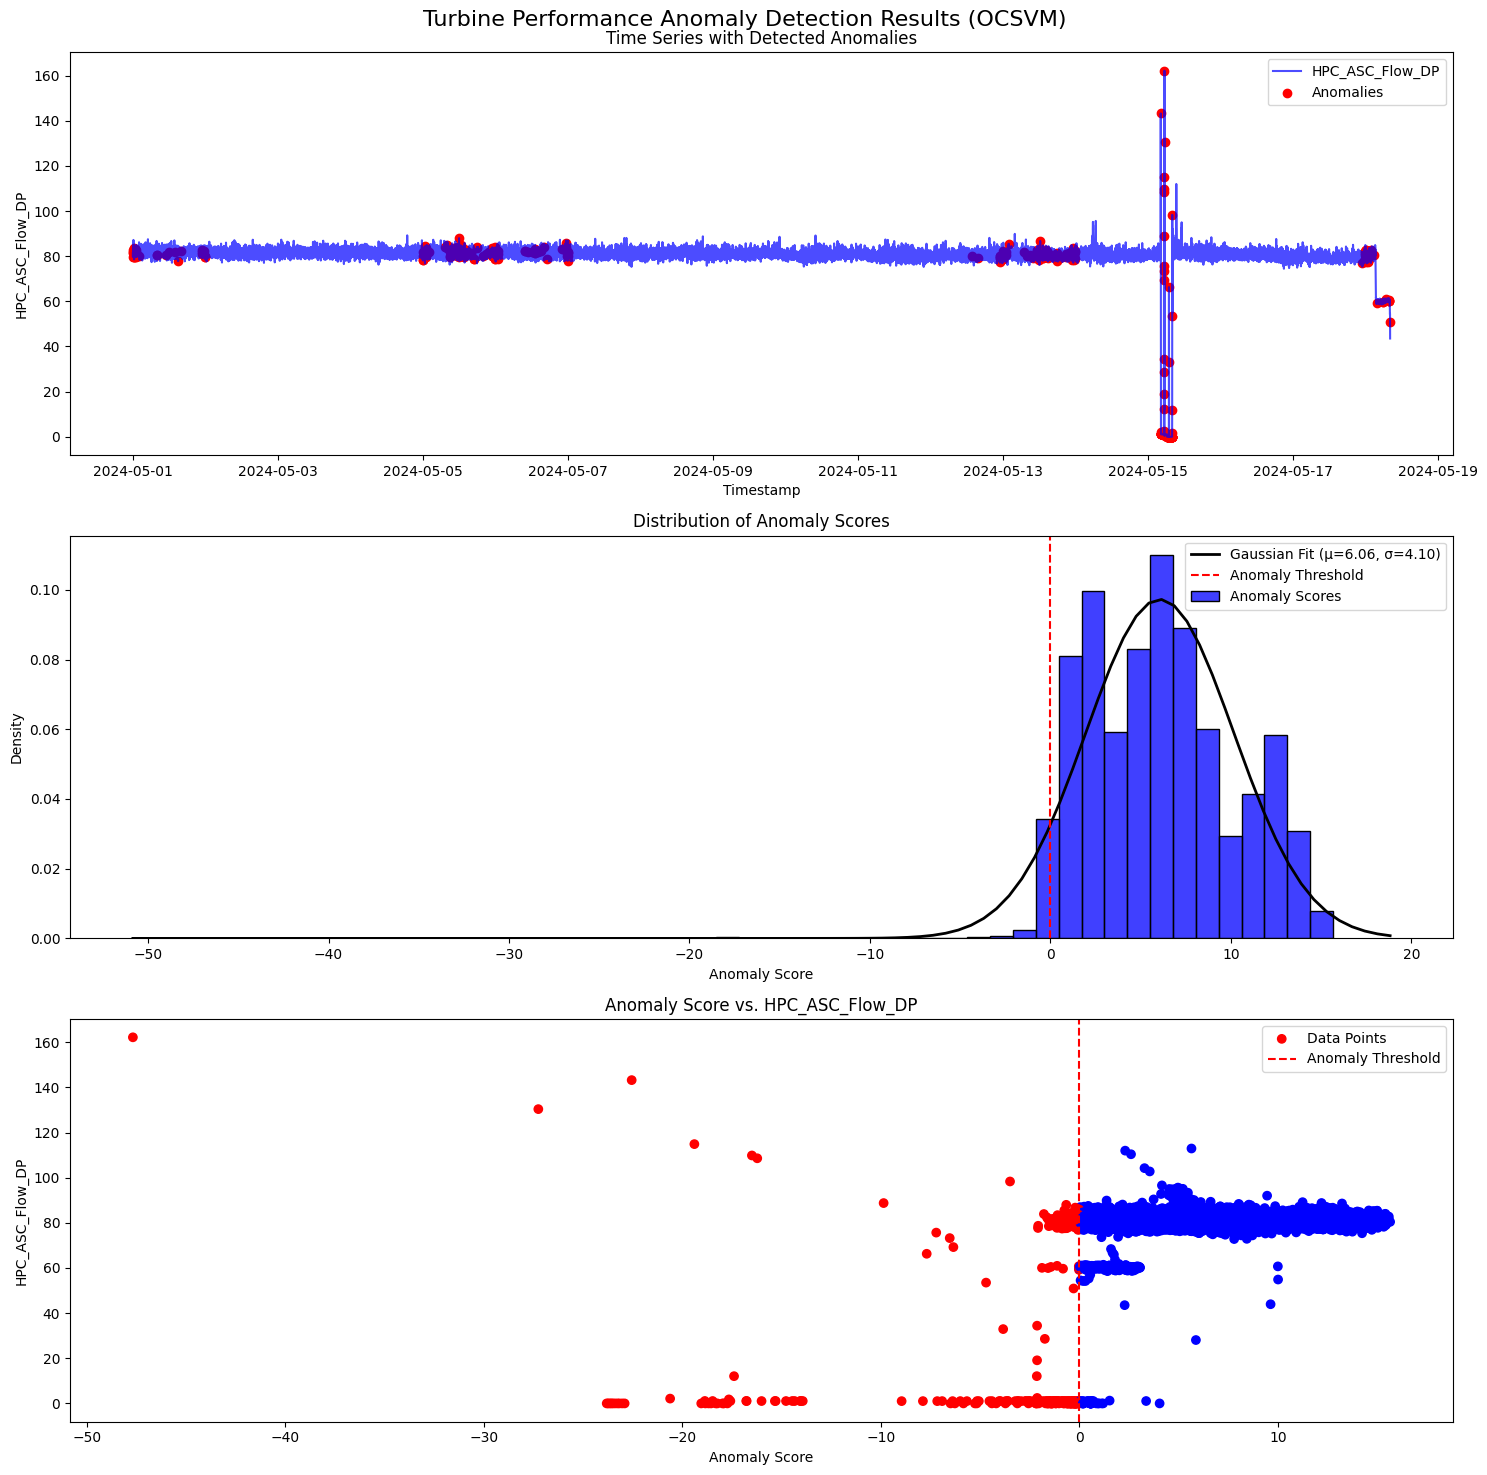

In [ ]:
# Visualization of the results (Enhanced)
total_samples = len(data_aggregated)
num_anomalies = data_aggregated['anomaly'].value_counts().get(-1, 0) # Handle case where no anomalies are found
anomaly_percentage = (num_anomalies / total_samples) * 100

print("Anomaly Detection Results:")
print(f"Total samples: {total_samples}")
print(f"Number of anomalies: {num_anomalies}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")

def plot_anomalies(data):
    """Plots time series, anomaly scores, and anomaly scatter plot."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle('Turbine Performance Anomaly Detection Results (OCSVM)', fontsize=16)

    # Plot 1: Time series with anomalies
    ax1.plot(data['MEAN_Timestamp'], data['MEAN_HPC_ASC_Flow_DP'], color='blue', label='HPC_ASC_Flow_DP', alpha=0.7)
    anomalies = data[data['anomaly'] == -1]
    ax1.scatter(anomalies['MEAN_Timestamp'], anomalies['MEAN_HPC_ASC_Flow_DP'], color='red', label='Anomalies')
    ax1.set_title('Time Series with Detected Anomalies')
    ax1.set_xlabel('Timestamp')  # Correct x-axis label
    ax1.set_ylabel('HPC_ASC_Flow_DP')
    ax1.legend()

    # Plot 2: Anomaly scores distribution
    sns.histplot(data=data, x='anomaly_score', bins=50, ax=ax2, kde=False, stat='density', color='blue', label='Anomaly Scores')
    mu, std = data['anomaly_score'].mean(), data['anomaly_score'].std() # Use actual data for fitting
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax2.plot(x, p, 'k', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')
    threshold = anomalies['anomaly_score'].max() if not anomalies.empty else None
    if threshold is not None:
        ax2.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')
    ax2.set_title('Distribution of Anomaly Scores')
    ax2.set_xlabel('Anomaly Score')
    ax2.set_ylabel('Density')
    ax2.legend()

    # Plot 3: Scatter plot of Anomaly Score vs. HPC_ASC_Flow_DP
    ax3.scatter(data['anomaly_score'], data['MEAN_HPC_ASC_Flow_DP'], c=data['anomaly'].map({1: 'blue', -1: 'red'}), label='Data Points')
    ax3.set_title('Anomaly Score vs. HPC_ASC_Flow_DP')
    ax3.set_xlabel('Anomaly Score')
    ax3.set_ylabel('HPC_ASC_Flow_DP')
    if threshold is not None:
        ax3.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')
    ax3.legend()

    plt.tight_layout()
    return fig

from scipy.stats import norm # Import norm for gaussian fit

fig = plot_anomalies(data_aggregated)
plt.show()